# CCA

https://github.com/gallantlab/pyrcca/blob/main/rcca/rcca.py

In [2]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

import h5py
import rcca
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from util.path import Path

from util import plot, subject
from util.atlas import Atlas
from constants import SUBS_STRANGERS

from os import environ
environ['TOKENIZERS_PARALLELISM'] = 'false'

# import warnings
# warnings.filterwarnings("ignore")

In [3]:
%cd ..

/scratch/gpfs/zzada/fconv


In [1]:
modelname = "model-opt-7b_layer-23"
features = ["task", "spectral", "articulation", "prod-LLM", "comp-LLM"]

encmodel = "encoding/trialmot6"
cache = encmodel.split("/")[-1]

modelname, encmodel, cache

('model-opt-7b_layer-23', 'encoding/trialmot6', 'trialmot6')

In [4]:
atlas = Atlas.schaefer2018(networks=7)
# networks = LabelEncoder().fit_transform([label.split("_")[2] for label in atlas.labels])
# len(np.unique(networks))

In [5]:
# resultCache = f"cache/{modelname}/{cache}/figure-gradients/"
# !mkdir -p $resultCache
# !ls -l $resultCache

# narrative

In [6]:
# not all subjects have this..
SUBS_NAR = list(SUBS_STRANGERS)
SUBS_NAR.remove(11)
SUBS_NAR.remove(111)
SUBS_NAR.remove(12)

## CCA-encoding

In [7]:
from black_encoding import build_regressors

In [8]:
X, features = build_regressors(modelname='opt-7b', layer=23)
feature_names = list(features.keys())
slices = list(features.values())

In [9]:
X.shape, slices, feature_names

((534, 4201),
 [slice(0, 3, None),
  slice(3, 83, None),
  slice(83, 105, None),
  slice(105, 4201, None)],
 ['task', 'spectral', 'phonetic', 'lexical'])

In [10]:
Xemb = X[:, features['spectral']]
Xemb.shape

(534, 80)

In [25]:
SUBS_NAR[0:2]

[104, 105]

In [26]:
cache_path = Path(
    root="data/derivatives/cleaned",
    datatype="func",
    sub="000",
    task="Black",
    space="fsaverage6",
    suffix="bold",
    ext="hdf5",
)

for i, sub in enumerate(tqdm(SUBS_NAR)):
    sub = 105
    # get BOLD data
    cache_path.update(sub=f"{sub:03d}")
    if cache_path.isfile():
        with h5py.File(cache_path, "r") as f:
            boldA = f["bold"][...]
    else:
        print("WARNING", sub)
        # boldA = get_bold(sub)

    # boldParcA = atlas.vox_to_parc(boldA)
    boldParcB = atlas.vox_to_parc(boldA)

    break

  0%|          | 0/55 [00:00<?, ?it/s]


In [21]:
regs = np.array(np.logspace(-4, 2, 10))
numCCs = np.arange(3, 11)
cca = rcca.CCACrossValidate(numCCs=numCCs, regs=regs)
cca.train([Xemb[:267], boldParcA[:267]])
ccaScores = cca.validate([Xemb[267:], boldParcA[267:]])
print(cca.best_numCC, cca.best_reg)

3 0.21544346900318823


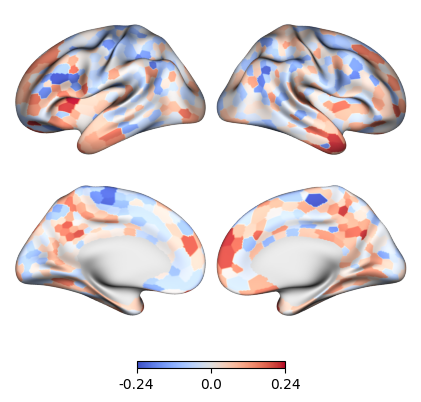

In [34]:
fig, ax = plt.subplots()
compVox = atlas.parc_to_vox(ccaScores[1])
plot.surface_plot(compVox, fig=fig, ax=ax)
fig.show()

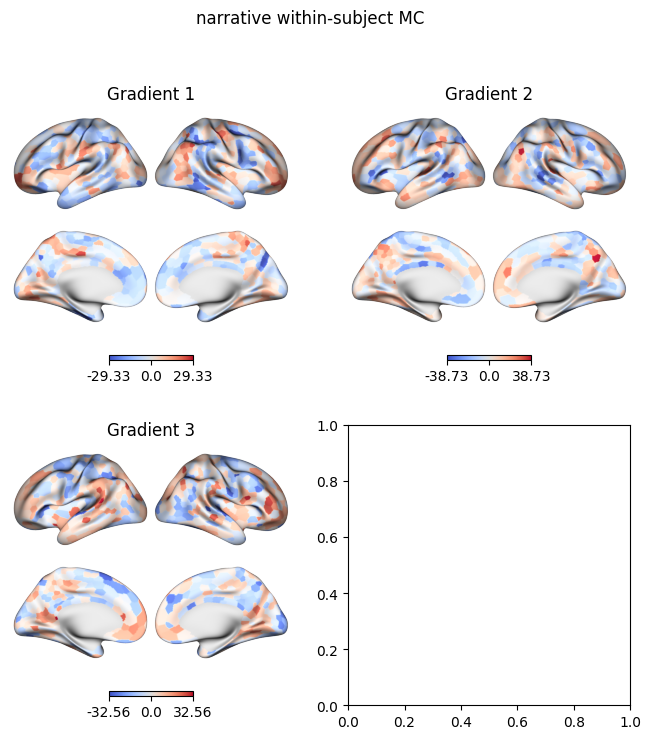

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, ax in zip(range(3), axes.ravel()):
    gradient = cca.ws[1][:, i]
    compVox = atlas.parc_to_vox(gradient)
    plot.surface_plot(compVox, title=f"Gradient {i+1}", fig=fig, ax=ax)

fig.suptitle("narrative within-subject MC")
fig.show()

## ridge

In [18]:
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.scoring import correlation_score

In [13]:
model = KernelRidgeCV(kernel="linear", alphas=np.logspace(-2, 2, 5))

model.fit(Xemb[:267], boldParcA[:267])

KernelRidgeCV(alphas=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]))

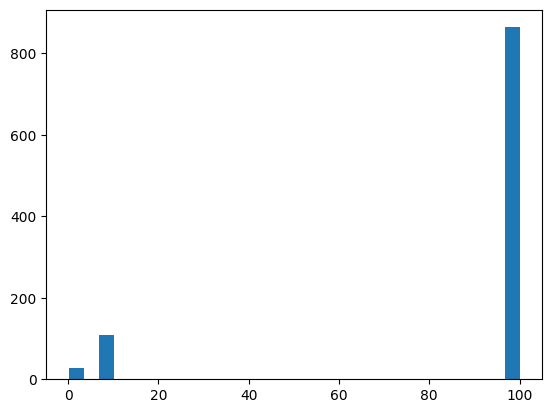

In [16]:
plt.hist(model.best_alphas_, bins=30);

In [19]:
ridgeScores = correlation_score(boldParcA[267:], model.predict(Xemb[267:]))
ridgeScores.shape

(1000,)

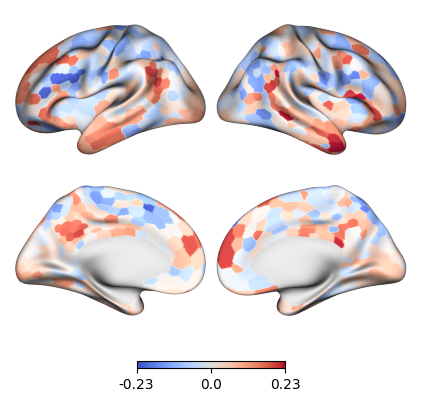

In [20]:
fig, ax = plt.subplots()
plot.surface_plot(atlas.parc_to_vox(ridgeScores), fig=fig, ax=ax)
fig.show()

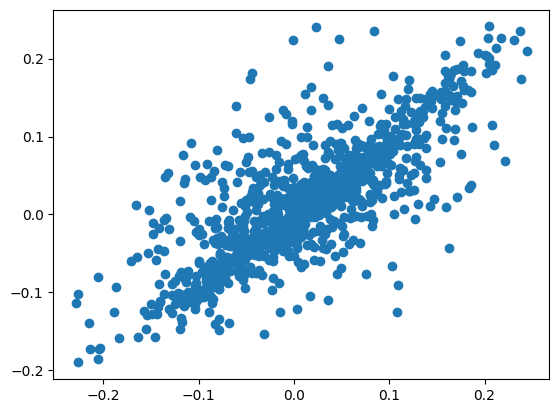

In [23]:
plt.scatter(ridgeScores, ccaScores[1]);

## ISC: dyadic CCA

In [28]:
regs = np.array(np.logspace(-4, 2, 10))
numCCs = np.arange(3, 11)

cca = rcca.CCACrossValidate(numCCs=numCCs, regs=regs)
cca.train([boldParcA[:267], boldParcB[:267]])
ccaScores = cca.validate([boldParcA[267:], boldParcB[267:]])
print(cca.best_numCC, cca.best_reg)

9 0.00046415888336127773


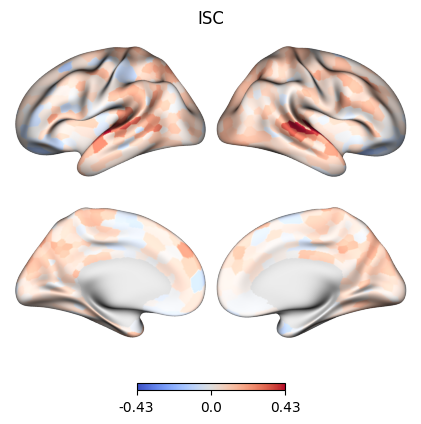

In [40]:
iscScores = correlation_score(boldParcA, boldParcB)
fig, ax = plt.subplots()
plot.surface_plot(atlas.parc_to_vox(iscScores), fig=fig, ax=ax, title='ISC')
fig.show()

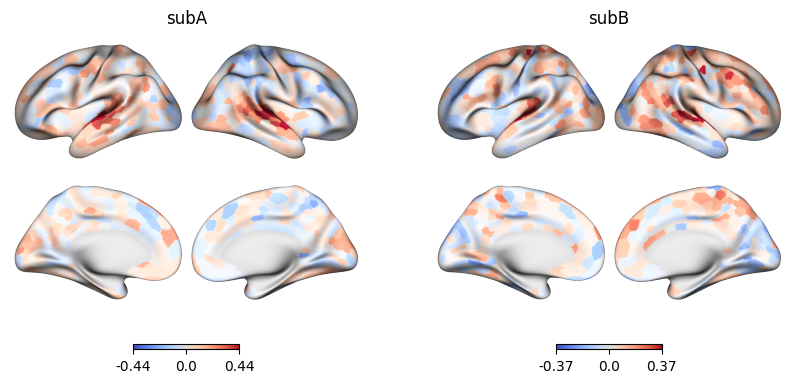

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot.surface_plot(atlas.parc_to_vox(ccaScores[0]), fig=fig, ax=axes[0], title='subA')
plot.surface_plot(atlas.parc_to_vox(ccaScores[1]), fig=fig, ax=axes[1], title='subB')
fig.show()

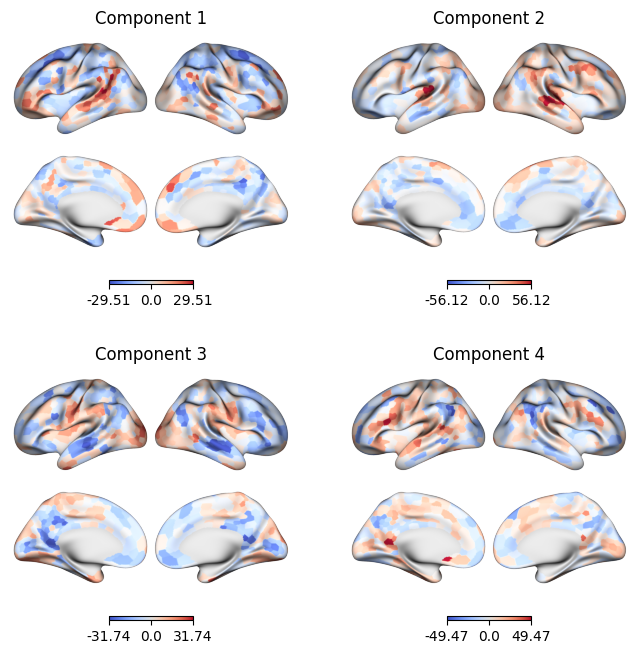

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i, ax in zip(range(4), axes.ravel()):
    gradient = cca.ws[1][:, i]
    compVox = atlas.parc_to_vox(gradient)
    plot.surface_plot(compVox, title=f"Component {i+1}", fig=fig, ax=ax)
fig.show()

# conversation

In [ ]:
# isc_scores = defaultdict(list)

regs = np.array(np.logspace(-4, 2, 10))
numCCs = np.arange(3, 11)

for subA in tqdm(SUBS_STRANGERS):
    # # load subA
    # encpath = Path(root="encoding", sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
    # with h5py.File(encpath, "r") as f:
    #     Y_predsA = f["cv_preds"][...]  # (5, 6, 240, 81924)
    #     nuis_predsA = Y_predsA[:, :-2].sum(1).reshape(1200, -1)
    #     in_prodA = f["in_prod"][...]
    #     in_compA = f["in_comp"][...]
    dataA = subject.get_bold(subA, use_cache=True)  # TODO cache_desc

    # # load subB
    subB = subject.get_partner(subA)
    # encpath = Path(root="encoding", sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
    # with h5py.File(encpath, "r") as f:
    #     Y_predsB = f["cv_preds"][...]
    #     nuis_predsB = Y_predsB[:, :-2].sum(1).reshape(1200, -1)
    dataB = subject.get_bold(subB, use_cache=True)

    dataA = atlas.vox_to_parc(stats.zscore(dataA))
    dataB = atlas.vox_to_parc(stats.zscore(dataB))

    cca = rcca.CCACrossValidate(numCCs=numCCs, regs=regs)
    cca.train([dataA[:600], dataB[:600]])
    cca.validate([dataA[600:], dataB[600:]])

    break
df = pd.DataFrame(atlas.labels)
df["subA"] = cca.corrs[0]
df["subB"] = cca.corrs[1]
df.sort_values("subA", ascending=False, inplace=True)
df